In [1]:
import numpy as np
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest
from math import ceil

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

random_state = 42
np.random.seed(random_state)

# 1 Успешность прототипа
Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Какими методами можно решать данную задачу? Предложите как минимум 2 варианта. Если у вас есть какой-то вариант решения задачи для которого требуются доп. данные - перечислите что требуется и метод решения.

# Решение 

1. Если возможен сбор данных о других играх, например: концепт, жанр, платформа, сеттинг, другие теги, затраты на рекламу, затраты на разработку, время разработки и т.д. Также если рассматривать результаты игры не как успех и неудача (классификация), а как регрессию, например отношение доходов к расходам (если главной целью пректа был доход), отношение кол-ва новых игроков к затраченным на рекламу средствам (если цель увеличение аудитории), другие метрики, по которым можно судить как хорошо проект справляется со своей целью. Также по обученным моделям судить о том, что необходимо игрокам и, опираясь на их предпочтения, создавать определенные игры.
2. Создание MVP и сбор отзывов, по которым можно судить о предпочтениях игроков, прибыли.

# 2 Сравнение групп платящих игроков
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.
1.	Опишите оптимальный по вашему мнению дизайн эксперимента
2.	Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.
3.	Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте доверительный интервал.
4.	Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, ДИ и ваши выводы для каждого варианта.
5.	Решите задачу 2 разными подходами: frequentist / bayesian

Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную методику расчета, алгоритм и т.д.

# Решение 

# Дизайн эксперимента
1. Формулировка гипотез: $H_0$ - обновление не изменит процент плательщиков (останется 10%), $H_1$ - процент плательщиков увеличится до 11%
2. Задание метрик. Основаная метрика - количество плательщиков среди новых игроков, также хорошо иметь и другие метрики и посмотреть их измениение в результате А/Б теста (суммарное количество денег оставленное плательщиками, кол-во оставшихся новых игроков игроков, время проводимое игроками в игре, и др.)
3. Разделение новых пользователей группы (в зависимости от количества других проводимых А/Б тестов, в зависимости от того, откуда пришел игрок(т.е. реклама на опредленном сайте, блогере, по чей рекомендации), какие-нибудь другие свойства (страна, платформа) и др.)
4. Определения значимости и мощности эксперимента, и расчет необходимого количества наблюдений (времени эксперимента)
5. Введение эксперимента и ожидание результатов.
6. Анализ результатов.

# Расчет длительности эксперимента

In [2]:
# новых игроков каждый день
new_players_per_day = 100
# время для определения поведения игрока
additional_test_days = 30

# доли 
p_0 = 0.1
p_1 = 0.11

# ошибки первого и второго рода
alpha = 0.05
beta = 0.2

# дисперсии (распределение Бернули)
var_0 = p_0 * (1 - p_0)
var_1 = p_1 * (1 - p_1)

# стандартизированный размер эффекта при равных размерах тестовой и контрольной групп
effect_size = (p_1 - p_0) / ((np.sqrt(var_0) + np.sqrt(var_1)) / 2)

# расчет необходимого числа наблюдений 
players_size = zt_ind_solve_power(effect_size=effect_size,  # стандартизованный размер эффекта
                                 nobs1=None,           # число наблюдений None, тк их хотим найти 
                                 alpha=alpha,          # уровень значимости 
                                 power=(1 - beta),     # мощность
                                 ratio=1,              # перекос в выборках, если 0, тогда выборка только одна
                                 alternative='larger'  # альтернатива
                                )

# округление в большую сторону
players_size = ceil(players_size)
print('Требуемое кол-во игроков для каждой группы:', players_size)

'''расчет времени эксперимента (необходимое число игроков, деленное на число новых игроков каждый день,
плюс время на совершение платежа в первые несколько дней'''
test_duration = players_size*2/new_players_per_day + additional_test_days
print('Время эксперимента в днях:', test_duration)

Требуемое кол-во игроков для каждой группы: 11612
Время эксперимента в днях: 262.24


При таком большом времени эксперимента (300 дней из-за малого количества новых пользователей и большого количества числа игроков), и таком малом размере эффекта (с 10% до 11%) имеет смысл не проводить этот А/Б тест, а направить ресурсы на реализацию функционала и проведение А/Б теста для того эксперимента который мог бы иметь больший размер эффекта. 

# Расчет доверительного интервала

In [3]:
# доля плательщиков
p = 0.1

# генерация датасета
random_state=42
control_data = stats.bernoulli.rvs(p, size=players_size,random_state=random_state)

# точечная оценка вероятности
nu = np.mean(control_data)

# расчет дисперсии 
var = control_data.var(ddof=1)

# количество наблюдений
n = control_data.size

# расчет квантиля 
z_crit = stats.norm.ppf(1-alpha/2)

# расчет доверительного интервала
left = nu - z_crit*np.sqrt(var/n)
right = nu + z_crit*np.sqrt(var/n)

print(f'Доверительный интервал для контрольной группы: {left:.4f} {right:.4f}')

Доверительный интервал для контрольной группы: 0.0913 0.1020


In [4]:
# расчет доверительного интревала для разности средних
def calc_interval_and_pvalue(control_data,test_data,alpha = 0.05,draw=False):
    
    # расчет средних значений
    nu_control = np.mean(control_data)
    nu_test = np.mean(test_data)
    
    # расчет дисперсий
    var_control = control_data.var(ddof=1)
    var_test = test_data.var(ddof=1)

    # количество наблюдений
    n_control = control_data.size
    n_test = test_data.size
    
    # расчет доверительного интервала
    z_crit = stats.norm.ppf(1-alpha/2)   
    sd = np.sqrt(var_control/n_control+var_test/n_test)
    left = (nu_test - nu_control) + z_crit*sd
    right = (nu_test - nu_control) - z_crit*sd
    left,right = min(left, right),max(left, right) 
    
    # число наблидений и число успехов для ztest`а
    n_obs = test_data.size, control_data.size                     
    m_obs = test_data.sum(), control_data.sum()                    

    # ztest
    z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0, alternative='two-sided')
    
    # вывод - отвергаем ли нулевую гипотезу
    is_reject = 'отвергается' if p_val<alpha else 'не отвергается'
             
    # отображение результатов теста
    if draw:
        print(f'Доверительный интервал: [{left:.4f}, {right:.4f}].\np-value: {p_val:.4f}\nНулевая гипотеза {is_reject}\n')
    return left, right, z_obs, p_val, is_reject

In [5]:
# процент плательщиков для разных групп 
p_mt = 0.11 # больше 
p_et = 0.1 # без эффекта
p_lt = 0.09 # меньше

# генерация групп
random_state=41
test_data_lt = stats.bernoulli.rvs(p_lt, size=players_size, random_state=random_state)
test_data_et = stats.bernoulli.rvs(p_et, size=players_size, random_state=random_state)
test_data_mt = stats.bernoulli.rvs(p_mt, size=players_size, random_state=random_state)

In [6]:
# расчет доверительных интервалов (не отвергаем нулевую гипотезу, если 0 входит в доверительный интервал) и p-value

print('Доля плательщиков в тесте -',p_lt)
left, right, z_obs, p_val,is_reject   = calc_interval_and_pvalue(control_data,test_data_lt,draw=True)

print('Доля плательщиков в тесте -',p_et)
left, right, z_obs, p_val,is_reject  = calc_interval_and_pvalue(control_data,test_data_et,draw=True)

print('Доля плательщиков в тесте -',p_mt)
left, right, z_obs, p_val,is_reject  = calc_interval_and_pvalue(control_data,test_data_mt,draw=True)

Доля плательщиков в тесте - 0.09
Доверительный интервал: [-0.0175, -0.0027].
p-value: 0.0078
Нулевая гипотеза отвергается

Доля плательщиков в тесте - 0.1
Доверительный интервал: [-0.0085, 0.0066].
p-value: 0.8066
Нулевая гипотеза не отвергается

Доля плательщиков в тесте - 0.11
Доверительный интервал: [0.0009, 0.0164].
p-value: 0.0294
Нулевая гипотеза отвергается



Байесовского подхода нет, увы

# 3 Предсказание оттока
В мобильной игре, после установки и запуска игры начинается туториал - игрок проходит обучение игре, которое состоит из нескольких последовательных шагов. 
Данные представляют собой набор строк - уникальный id игрока, datetime и номер шага туториала который пройден игроком.
Геймдизайнеры выдвинули гипотезу - если мы с высокой вероятностью сможем предсказать шаг на котором игрок уйдет из игры заранее, то запустив альтернативное продолжение туториала с этого шага мы избежим оттока и увеличим прохождение туториала.
1.	Как бы вы решали задачу предсказания отвала игрока?
2.	Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.
3.	Предположим что вы разработали модель которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров


# Решение 

1. Можно на основе данных игрока создать модель (классификатор), которая будет предсказывать уход игрока. По datetime, а также по другим параметрам, если возможен их сбор, такие как своства игрока (страна, возраст и др.), то как он проходит уровень (время потраченное на уровень в сравнении с другими игроками, какие-либо действия в игре в зависимости от жанра, и т.д.), запустить альтернативный туториал (или один из нескольких альтернативных туториалов в дальнейшем, например создание для кажого туториала модели, которые буду предстазывать необходимость смены текущего утториала на определенный другой туториал).  
2. Оценку качества модели можно производить с помощью метрики recall, т.к. мы хотим предсказать наибольшее количество игроков собирающихся покинуть игру. Также можно использовать взвешенный f-score, для учета того, во сколько раз recall для нас вожнее чем precition.
3. 
    
    1. Формулировка гипотез: количество игроков проходящих туториал до конца.
    2. Задание метрик. Основаная метрика - доля игроков проходящих туториал полностью, также хорошо иметь и другие метрики и посмотреть их измениение в результате А/Б теста (продолжает ли игрок играть в игру спустя определнное время, провести опрос после туториала и узнать доволен ли игрок туториалом)
    3. Разделение новых пользователей группы (в зависимости от количества других проводимых А/Б тестов, в зависимости от того, откуда пришел игрок (т.е. реклама на опредленном сайте, блогере, по чей рекомендации), какие-нибудь другие свойства (страна, платформа) и др.)
    4. Определения значимости и мощности эксперимента, и расчет необходимого количества наблюдений (времени эксперимента)
    5. Введение эксперимента и ожидание результатов.
    6. Анализ результатов.

    

# 4 Эффективность рекламных кампаний
Отдел маркетинга оперирует некоторым множеством рекламных кампаний. Первая часть оперирования состоит из запуска тестовых рекламных кампаний, у которых есть требования по KPI при достижении которых тест считается успешным.
Успешные тесты переходят в разряд постоянных кампаний и вторая часть оперирования состоит из мониторинга постоянных кампаний - управление бюджетом кампании (COST) и мониторинг ее доходов (REVENUE), а так же соотношением доходов к расходам.
Главный KPI для постоянных рекламных кампаний - ROAS на 60й день, т.е. какой процент от расходов кампания возвращает на 60й день.
Для выполнения задачи необходимо использовать тестовый датасет (2 таблицы по расходам и доходам).
1.	Отдел маркетинга руководствуется гипотезой - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня (рост CPI при увеличении объёма закупки при сохранении того же LTV 60го дня). На основании данных подтвердите или опровергните эту гипотезу. Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.
2.	По каждой рекламной кампании рассчитайте суточный рекламный бюджет который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST).
3.	Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.
4.	Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально


# Решение 

Тоже нет, увы2

In [7]:
# подключение у базе данных
path = 'testcase.db'
db = sqlite3.connect(path)
cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('source_comparison',), ('costs',), ('revenue',)]

In [8]:
cursor.execute('select * from costs')
columns_names = [i[0] for i in cursor.description]
data = cursor.fetchall()
costs_df = pd.DataFrame(data,columns=columns_names)
costs_df['Install_Dates'] = pd.to_datetime(costs_df['Install_Dates'])
costs_df.head()

,Install_Dates,campaign_id,Country,installs,spends
0,2020-04-14,90570,CZ,35.0,19.79
1,2020-04-28,90619,AT,5.0,4.99
2,2020-05-10,794235,PK,79.0,0.40
3,2020-05-07,91872,FR,12.0,9.56
4,2020-04-03,19115,JP,6.0,3.39


In [9]:
cursor.execute('select * from revenue')
columns_names = [i[0] for i in cursor.description]
data = cursor.fetchall()
revenue_df = pd.DataFrame(data,columns=columns_names)
revenue_df['Install_Dates'] = pd.to_datetime(revenue_df['Install_Dates'])
revenue_df.head()

,Install_Dates,campaign_id,Country,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,2020-04-14,90570,CZ,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
1,2020-03-30,90262,CA,1.424363,1.724738,1.724738,1.724738,1.724738,1.999413
2,2020-04-02,19115,PL,26.912006,32.943050,66.787497,70.071922,71.644023,72.057026
3,2020-04-15,788948,MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-03-26,158583,DE,0.349793,0.349793,0.349793,0.349793,0.349793,0.349793


In [10]:
# джоин двух df
CR_df = pd.merge(costs_df,
                 revenue_df,
                 how ='outer',
                 left_on=['Install_Dates', 'campaign_id', 'Country'],
                 right_on=['Install_Dates', 'campaign_id', 'Country']
                )
CR_df.head()

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652


In [11]:
# замена -1 на np.nan
CR_df['60d_LTV'] = CR_df['60d_LTV'].replace(-1,np.nan)

# расчет revenue
CR_df['revenue'] = CR_df['60d_LTV']*CR_df['installs']
CR_df.head()

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV,revenue
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420,551.894708
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,NaN,NaN
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,NaN,NaN
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,NaN,NaN
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652,8.499912


In [12]:
# корреляционная матрица из который водно что LTV с 1 по 30 дней имею высокую корреляцию с LTV 60 дня
CR_df[['1d_LTV', '3d_LTV', '7d_LTV', '14d_LTV', '30d_LTV', '60d_LTV']].corr()

,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
1d_LTV,1.000000,0.996558,0.987949,0.982467,0.977364,0.974049
3d_LTV,0.996558,1.000000,0.991967,0.986594,0.981347,0.978570
7d_LTV,0.987949,0.991967,1.000000,0.995078,0.989467,0.987576
14d_LTV,0.982467,0.986594,0.995078,1.000000,0.995395,0.992169
30d_LTV,0.977364,0.981347,0.989467,0.995395,1.000000,0.997040
60d_LTV,0.974049,0.978570,0.987576,0.992169,0.997040,1.000000


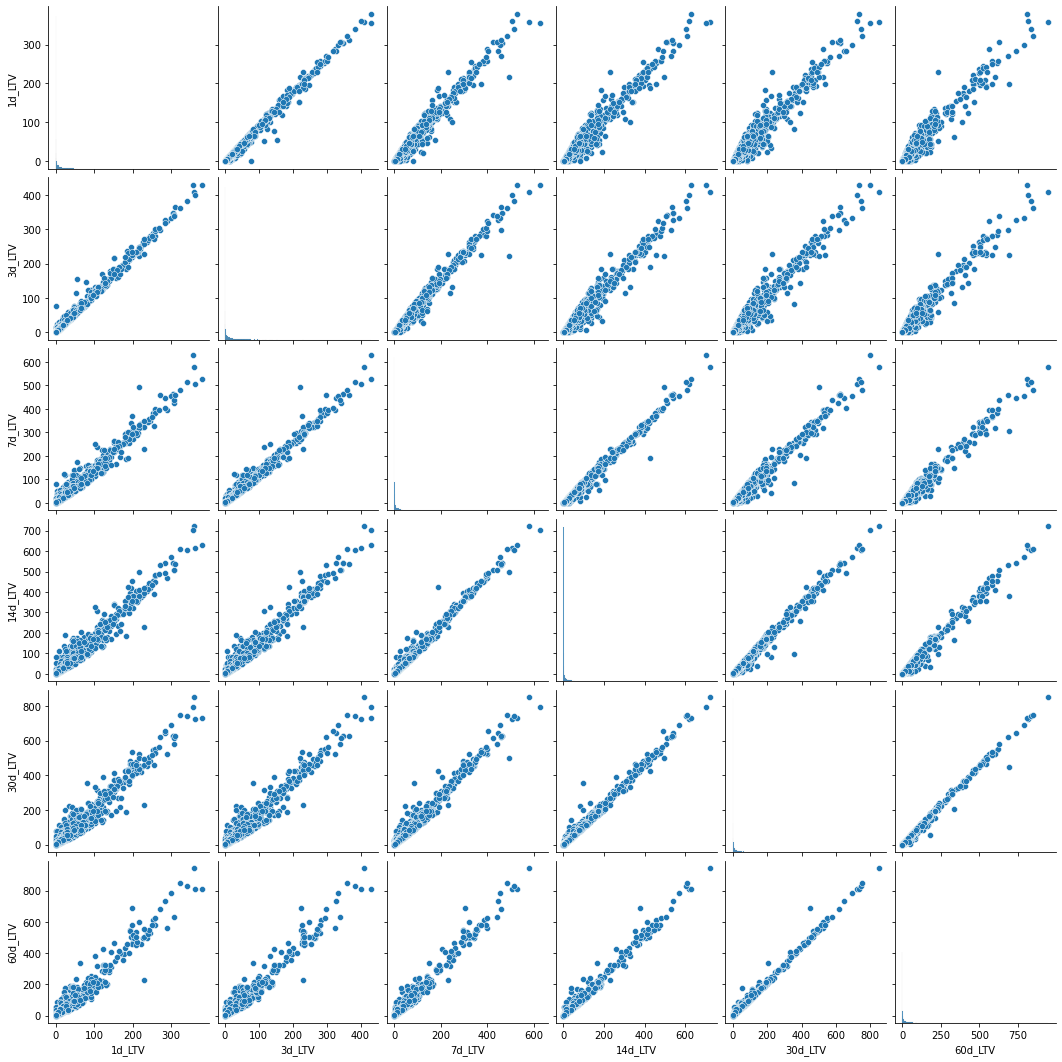

In [13]:
sns.pairplot(CR_df[['1d_LTV', '3d_LTV', '7d_LTV', '14d_LTV', '30d_LTV', '60d_LTV']])

Из-за высокой корреляции LTV 60 дня с предыдущими для прогноза отсутсвующих 60d_LTV расчитаем отношения предыдущих LTV к отсутсвующим, затем опираясь на значения i-ого LTV и отношения i-ого LTV к 60d_LTV расчитаем 60d_LTV.

In [14]:
#расчет для каждой компании количетсва наблюдений
campaign_count = CR_df.groupby('campaign_id')['campaign_id'].agg('count')
campaign_count = campaign_count.sort_values(ascending=False)

campaigns_treshhold = 10
active_campaigns = campaign_count[campaign_count>10]
active_campaigns

campaign_id
19115     1645
794235    1353
22083      578
792410     319
90619      204
          ... 
790391      11
787244      11
789505      11
789191      11
92412       11
Name: campaign_id, Length: 174, dtype: int64

In [15]:
# сортировка для получения коэффициентов для расчета 60d_LTV
LTV_df = CR_df[(CR_df['60d_LTV']!=0) & (CR_df.spends !=0) & (CR_df['60d_LTV'].notna())]

# числитель в отношении 60d_LTV к i d_LTV
numerator = '60d_LTV'

# знаменатели в отношении 
to_find_60d_LTV_col = ['1d_LTV', '3d_LTV', '7d_LTV', '14d_LTV', '30d_LTV']

for denumerator in to_find_60d_LTV_col:
    LTV_df[numerator+'_by_'+denumerator] = LTV_df[numerator]/LTV_df[denumerator]
LTV_df = LTV_df.iloc[:,-5:]
LTV_df = LTV_df.describe()
LTV_df

<ipython-input-15-0ee3f6150554>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LTV_df[numerator+'_by_'+denumerator] = LTV_df[numerator]/LTV_df[denumerator]


,60d_LTV_by_1d_LTV,60d_LTV_by_3d_LTV,60d_LTV_by_7d_LTV,60d_LTV_by_14d_LTV,60d_LTV_by_30d_LTV
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,inf,inf,inf,inf,inf
std,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.349470,1.237846,1.069673,1.006007,1.000000
50%,2.023924,1.800701,1.368162,1.145716,1.023907
75%,2.837458,2.423473,1.734219,1.344850,1.097516
max,inf,inf,inf,inf,inf


Из-за малых значений расходов и больших доходов имеются большие хвосты, из-за чего для расчета будет использована медиана

In [16]:
# медианные занчения
LTV_ratio = LTV_df.loc['50%',:].to_numpy()
LTV_ratio

array([2.02392424, 1.800701  , 1.36816199, 1.14571607, 1.02390677])

In [17]:
# LTV до 60 дня
prev_LTV = CR_df[to_find_60d_LTV_col].to_numpy()

# предстазанные зачения 60d_LTV
predicted_60d_LTV = np.mean(prev_LTV*LTV_ratio,axis=1)

# отброс неизвестных значений для расчета метрик 
predicted_LTV = predicted_60d_LTV[CR_df['60d_LTV'].notna()]
true_LTV = CR_df[CR_df['60d_LTV'].notna()]['60d_LTV']

In [18]:
# метрики 
MAPE = mean_absolute_percentage_error(true_LTV, predicted_LTV)
R2 = r2_score(true_LTV, predicted_LTV)
print(f'MAPE: {MAPE:.3f}')
print(f'r2_score: {R2:.3f}')

MAPE: 0.214
r2_score: 0.965


# 5 Связь рекламного траффика и органического
Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.
Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).
1.	Подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее
2.	Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна


# Решение 

In [19]:
# подключение к базе данных
path = 'testcase.db'
db = sqlite3.connect(path)
cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('source_comparison',), ('costs',), ('revenue',)]

In [20]:
# загрузка данных о источниках игроков
cursor.execute('select * from source_comparison')
columns_names = [i[0] for i in cursor.description]
data = cursor.fetchall()
df = pd.DataFrame(data,columns=columns_names)
print(df.shape)
df.head()

(18606, 4)


,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


In [21]:
df['Install_Dates'].nunique()

61

In [22]:
# группировка рекламного и органического трафика по дням
target = ['Install_Dates']
paid_source =  df[df['source_type'] == 'Paid'].groupby(target)["installs"].agg(sum)
organic_source = df[df['source_type'] == 'Organic'].groupby(target)["installs"].agg(sum)
source_df = pd.DataFrame({'paid':paid_source,'organic':organic_source})
source_df.head()

,paid,organic
Install_Dates,,
2020-03-18,7359.0,8961.0
2020-03-19,6739.0,8457.0
2020-03-20,7254.0,8819.0
2020-03-21,9552.0,4485.0
2020-03-22,14804.0,5105.0


In [23]:
# коэффициент корреляции Пирсона
source_df.corr(method='pearson')

,paid,organic
paid,1.000000,0.224341
organic,0.224341,1.000000


In [24]:
# коэффициент корреляции Спирмана
source_df.corr(method='spearman')

,paid,organic
paid,1.000000,0.538109
organic,0.538109,1.000000


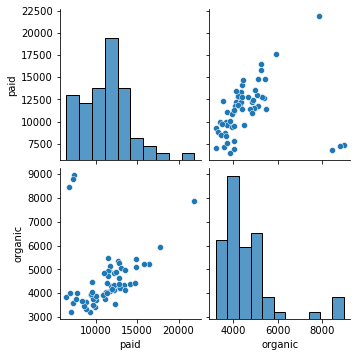

In [25]:
sns.pairplot(source_df)

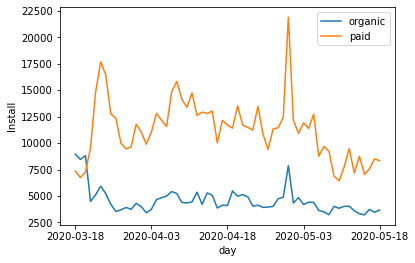

In [26]:
plt.plot(source_df.organic,label='organic')
plt.plot(source_df.paid,label='paid')
plt.xticks(plt.xticks()[0][0::15])
plt.ylabel('Install')
plt.xlabel('day')
plt.legend()

Из графиков видно, что в первые 3 дня скорее всего являются выбросами или в ту дату произошел структурный сдвиг (возможно проанализировать Байесовскими методами при большем объеме данных, также возможно такое поведение данных - результат политики компании, или влияние каких-нибудь других факторов). Если отбросить первые дни, то:

In [27]:
# отбросим выбросы
source_df = source_df[source_df.paid>source_df.organic]

# коэффициент корреляции Пирсона
source_df.corr(method='pearson')

,paid,organic
paid,1.000000,0.806232
organic,0.806232,1.000000


По расчитанному коэффициенту корреляции видно, что органический и рекламный трафик имеют высокую корреляцию.